<a href="https://colab.research.google.com/github/hariansyahputra/Classification-Hijab-Use-Tensorflow-And-Implementation-Model-With-Augmented-Reality-in-Lens-Studio/blob/main/CNN%20500%20Data%20Fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
base_dir = '/content/drive/My Drive/Dataset Classification 500'

train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir, 'validation')

train_hijab_dir = os.path.join(train_dir, 'hijab')

train_nonhijab_dir = os.path.join(train_dir, 'nonhijab')

valid_hijab_dir = os.path.join(validation_dir, 'hijab')

valid_nonhijab_dir = os.path.join(validation_dir, 'nonhijab')

In [4]:
train_hijab_names = os.listdir(train_hijab_dir)
print(train_hijab_names[:10])

validation_hijab_names = os.listdir(valid_hijab_dir)
print(validation_hijab_names[:10])

train_nonhijab_names = os.listdir(train_nonhijab_dir)
print(train_nonhijab_names[:10])

['hijab.0105.jpg', 'hijab.0101.jpg', 'hijab.0116.jpg', 'hijab.0005.jpg', 'hijab.0069.jpg', 'hijab.0009.jpg', 'hijab.0038.jpg', 'hijab.0027.jpg', 'hijab.0142.jpg', 'hijab.0098.jpg']
['hijab.2019.jpg', 'hijab.2005.jpg', 'hijab.2011.jpg', 'hijab.2010.jpg', 'hijab.2044.jpg', 'hijab.2034.jpg', 'hijab.2007.jpg', 'hijab.2017.jpg', 'hijab.2033.jpg', 'hijab.2015.jpg']
['nonhijab.0180.jpg', 'nonhijab.0085.jpg', 'nonhijab.0001.jpg', 'nonhijab.0138.jpg', 'nonhijab.0141.jpg', 'nonhijab.0165.jpg', 'nonhijab.0015.jpg', 'nonhijab.0120.jpg', 'nonhijab.0053.jpg', 'nonhijab.0007.jpg']


In [5]:
print('train hijab images : ',len(os.listdir(train_hijab_dir)))
print('train nonhijab images:', len(os.listdir(train_nonhijab_dir)))
print('validation hijab images :', len(os.listdir(valid_hijab_dir)))
print('validation non hijab images :',len(os.listdir(valid_nonhijab_dir)))

train hijab images :  200
train nonhijab images: 200
validation hijab images : 50
validation non hijab images : 50


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0



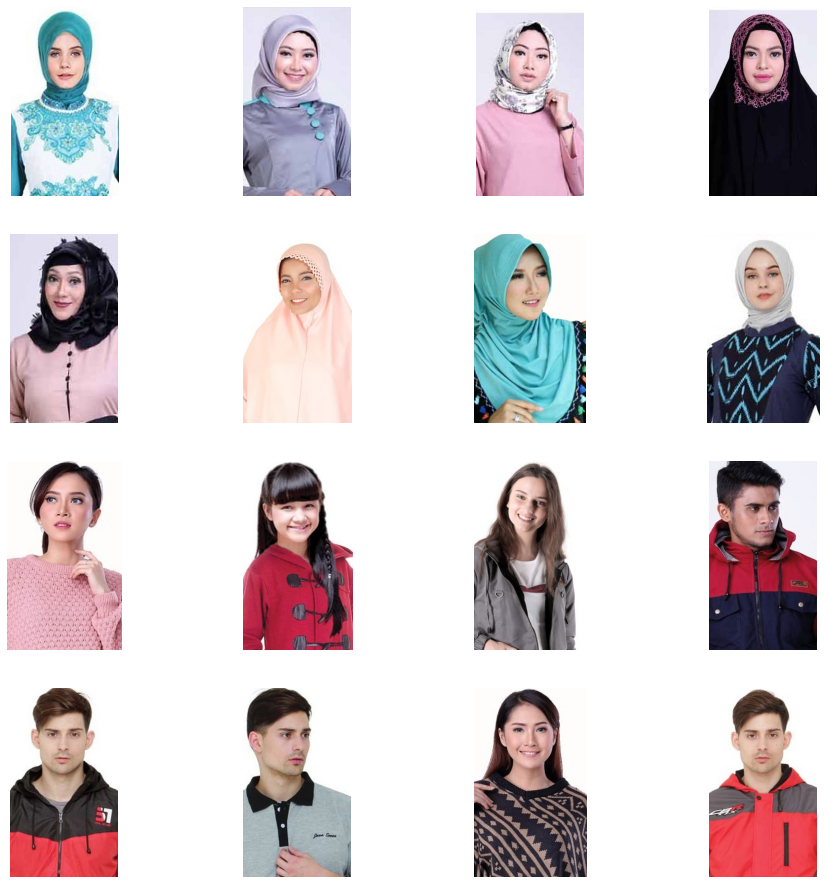

In [7]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches ( ncols*4, nrows*4)

pic_index += 8

next_hijab_pic = [os.path.join(train_hijab_dir,fname) 
for fname in train_hijab_names [pic_index -8 :pic_index]]
next_nonhijab_pic = [os.path.join(train_nonhijab_dir,fname)
for fname in train_nonhijab_names [pic_index-8 :pic_index]]

for i, img_path in enumerate(next_hijab_pic + next_nonhijab_pic):
    # Set up subplot; subplot indices start at 1

    sp = plt.subplot (nrows, ncols, i+1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale = 1/255,
                                   rotation_range = 0.2,
                                   zoom_range =0.2,
                                   shear_range = 0.2,
                                   fill_mode = 'nearest',
                                   )

valid_datagen = ImageDataGenerator(rescale = 1/255,
                                   rotation_range = 0.2,
                                   zoom_range =0.2,
                                   shear_range = 0.2,
                                   fill_mode = 'nearest'
                                   )

# Flow training images in batches of 120 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 4,
    class_mode = 'binary'
)

valid_generator = valid_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 4,
    class_mode = 'binary'
)

Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


Building the CNN model

In [9]:
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve , auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

from scipy import interp

In [10]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 200x200 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('dandelions') and 1 for the other ('grass')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 36, 36, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        1

In [12]:
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import TensorBoard

model.compile(loss= 'binary_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ["accuracy",tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [13]:
callbacks = TensorBoard(log_dir='./Graph')
history = model.fit(
    train_generator,
    steps_per_epoch =100 , # 400 images = batchsize * step/epoch ( 100*4)
    epochs = 10,
    verbose = 1,
    validation_data = valid_generator,
    validation_steps = 5,
    callbacks=[callbacks]
)

Epoch 1/10
100/100 [==============================] - 57s 549ms/step - loss: 1.0672 - accuracy: 0.5900 - precision: 0.5918 - recall: 0.5800 - val_loss: 0.6756 - val_accuracy: 0.8000 - val_precision: 0.7500 - val_recall: 0.7500
Epoch 2/10
100/100 [==============================] - 48s 476ms/step - loss: 0.6776 - accuracy: 0.6975 - precision: 0.6872 - recall: 0.7250 - val_loss: 0.5514 - val_accuracy: 0.7500 - val_precision: 1.0000 - val_recall: 0.5455
Epoch 3/10
100/100 [==============================] - 44s 443ms/step - loss: 0.4900 - accuracy: 0.7850 - precision: 0.8000 - recall: 0.7600 - val_loss: 0.2469 - val_accuracy: 0.8500 - val_precision: 0.7857 - val_recall: 1.0000
Epoch 4/10
100/100 [==============================] - 58s 579ms/step - loss: 0.4051 - accuracy: 0.8400 - precision: 0.8542 - recall: 0.8200 - val_loss: 0.4823 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 0.8889
Epoch 5/10
100/100 [==============================] - 52s 522ms/step - loss: 0.3336 - accura

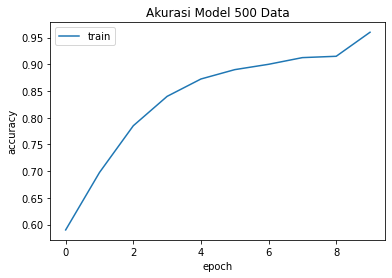

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('Akurasi Model 500 Data')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

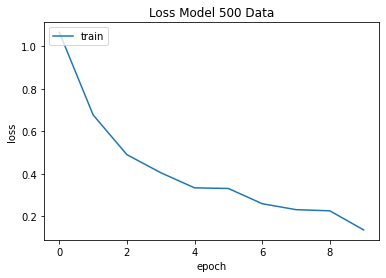

In [18]:
plt.plot(history.history['loss'])
plt.title('Loss Model 500 Data')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

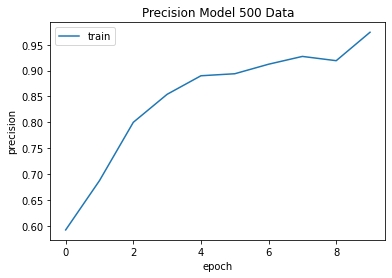

In [19]:
plt.plot(history.history['precision'])
plt.title('Precision Model 500 Data')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

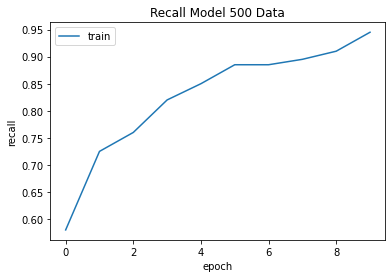

In [20]:
plt.plot(history.history['recall'])
plt.title('Recall Model 500 Data')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

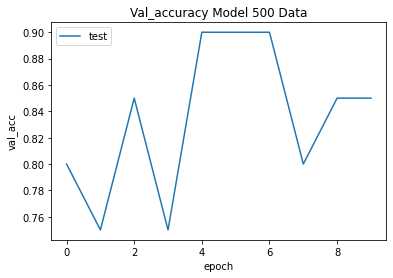

In [22]:
plt.plot(history.history['val_accuracy'])
plt.title('Val_accuracy Model 500 Data')
plt.ylabel('val_acc')
plt.xlabel('epoch')
plt.legend(['test', 'train'], loc='upper left')
plt.show()

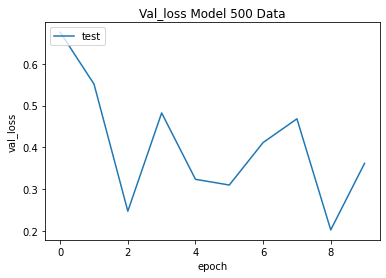

In [23]:
plt.plot(history.history['val_loss'])
plt.title('Val_loss Model 500 Data')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['test', 'train'], loc='upper left')
plt.show()

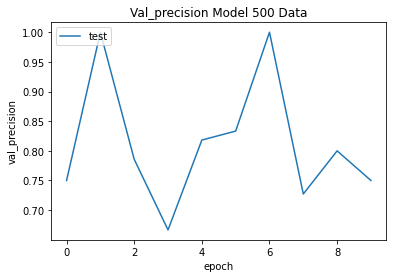

In [24]:
plt.plot(history.history['val_precision'])
plt.title('Val_precision Model 500 Data')
plt.ylabel('val_precision')
plt.xlabel('epoch')
plt.legend(['test', 'train'], loc='upper left')
plt.show()

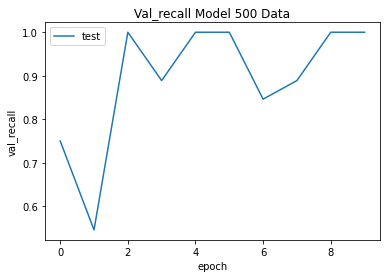

In [25]:
plt.plot(history.history['val_recall'])
plt.title('Val_recall Model 500 Data')
plt.ylabel('val_recall')
plt.xlabel('epoch')
plt.legend(['test', 'train'], loc='upper left')
plt.show()

In [26]:
model.evaluate(valid_generator)

25/25 [==============================] - 4s 173ms/step - loss: 0.3971 - accuracy: 0.8600 - precision: 0.8214 - recall: 0.9200


[0.3971441388130188,
 0.8600000143051147,
 0.8214285969734192,
 0.9200000166893005]